# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [46]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [48]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в этой функции.
Вычислите градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)


In [58]:
# TODO: Implement gradient check function
def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [59]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [60]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
print(probs)
linear_classifer.cross_entropy_loss(probs, 1)

[4.50940412e-05 6.69254912e-03 9.93262357e-01]


5.006760294127235

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [61]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
print(loss, grad)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

0.5171482364045897 [ 0.19203896 -0.26268615  0.07064719]
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [62]:
# TODO Extend combined function so it can receive a 2d array with batch of samples

# Test batch_size = 1
batch_size = 1
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
batch_size = 3
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [63]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [64]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [65]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

func 2.301217746788605
reg 0.30687064269016695
[[ 0.03158426  0.01534869 -0.00938949 ... -0.0382656  -0.03449836
  -0.01124575]
 [-0.02025662  0.00628495 -0.01816048 ... -0.02849496 -0.01088765
   0.00221845]
 [-0.02301987  0.00751396 -0.01201277 ... -0.02115422  0.0164509
  -0.02441687]
 ...
 [-0.00996785 -0.01989827 -0.01352461 ... -0.0041169  -0.02026529
  -0.00987872]
 [-0.02108818 -0.03219076  0.03766409 ...  0.01018137 -0.00782114
  -0.00414202]
 [ 0.00289812 -0.01624426 -0.03242273 ...  0.03011014 -0.0017953
   0.00172189]]
func 2.32077455750684
reg 110.7798115398323
[[-0.60011293 -0.2916349   0.17839208 ...  0.72704109  0.65545951
   0.2136617 ]
 [ 0.38486398 -0.11942343  0.34504092 ...  0.54139903  0.20685627
  -0.04215803]
 [ 0.43736149 -0.14277857  0.22823027 ...  0.40192055 -0.31258051
   0.46390908]
 ...
 [ 0.18937744  0.37805653  0.25695894 ...  0.07821511  0.38503064
   0.18768786]
 [ 0.40065477  0.61160525 -0.71563541 ... -0.1934613   0.14858271
   0.07868162]
 [-0.0570

func 19.47986988666963
reg 5.884056972091216e+78
[[-1.38306818e+38 -6.72121897e+37  4.11136653e+37 ...  1.67559849e+38
   1.51061537e+38  4.92414804e+37]
 [ 8.86976143e+37 -2.75230355e+37  7.95207886e+37 ...  1.24775709e+38
   4.76735926e+37 -9.71778989e+36]
 [ 1.00796331e+38 -3.29056320e+37  5.25997251e+37 ...  9.26304366e+37
  -7.20393995e+37  1.06914794e+38]
 ...
 [ 4.36442350e+37  8.71288462e+37  5.92202713e+37 ...  1.80266983e+37
   8.87362916e+37  4.32582584e+37]
 [ 9.23364424e+37  1.40954050e+38 -1.64930330e+38 ... -4.45857595e+37
   3.42428224e+37  1.81367407e+37]
 [-1.31284446e+37  7.06942752e+37  1.41538253e+38 ... -1.32289322e+38
   7.42420546e+36 -8.22045226e+36]]
func 19.89433520342855
reg 2.1241445669249303e+81
[[ 2.62782955e+39  1.27703160e+39 -7.81159641e+38 ... -3.18363714e+39
  -2.87016919e+39 -9.35588127e+38]
 [-1.68525467e+39  5.22937674e+38 -1.51089498e+39 ... -2.37073847e+39
  -9.05798260e+38  1.84638008e+38]
 [-1.91513029e+39  6.25207009e+38 -9.99394778e+38 ... -

func 20.101567861808018
reg 1.412048828544098e+140
[[-6.77532315e+68 -3.29256584e+68  2.01406100e+68 ...  8.20835978e+68
   7.40014655e+68  2.41222339e+68]
 [ 4.34508585e+68 -1.34828826e+68  3.89553492e+68 ...  6.11246618e+68
   2.33541628e+68 -4.76051489e+67]
 [ 4.93777331e+68 -1.61196890e+68  2.57673584e+68 ...  4.53774549e+68
  -3.52903940e+68  5.23750230e+68]
 ...
 [ 2.13802761e+68  4.26823562e+68  2.90106070e+68 ...  8.83085212e+67
   4.34698056e+68  2.11911953e+68]
 [ 4.52334341e+68  6.90500477e+68 -8.07954585e+68 ... -2.18415066e+68
   1.67747469e+68  8.88475929e+67]
 [-6.43131375e+67  3.46314495e+68  6.93362345e+68 ... -6.48054027e+68
   3.63694225e+67 -4.02700468e+67]]
func 19.54894743946278
reg 5.097496271044196e+142
[[ 1.28731140e+70  6.25587509e+69 -3.82671589e+69 ... -1.55958836e+70
  -1.40602785e+70 -4.58322443e+69]
 [-8.25566311e+69  2.56174769e+69 -7.40151634e+69 ... -1.16136857e+70
  -4.43729094e+69  9.04497829e+68]
 [-9.38176929e+69  3.06274092e+69 -4.89579809e+69 ...

[[-3.31907019e+99 -1.61294995e+99  9.86640735e+98 ...  4.02108086e+99
   3.62515636e+99  1.18169105e+99]
 [ 2.12855455e+99 -6.60494454e+98  1.90833020e+99 ...  2.99435227e+99
   1.14406507e+99 -2.33206339e+98]
 [ 2.41889809e+99 -7.89665351e+98  1.26228180e+99 ...  2.22293394e+99
  -1.72879274e+99  2.56572821e+99]
 ...
 [ 1.04736904e+99  2.09090744e+99  1.42116086e+99 ...  4.32602510e+98
   2.12948272e+99  1.03810642e+99]
 [ 2.21587870e+99  3.38259814e+99 -3.95797797e+99 ... -1.06996363e+99
   8.21755082e+98  4.35243295e+98]
 [-3.15054814e+98  1.69651261e+99  3.39661775e+99 ... -3.17466304e+99
   1.78165179e+98 -1.97273412e+98]]
func 17.683853514047605
reg 1.2232909491149436e+204
[[ 6.30623336e+100  3.06460490e+100 -1.87461740e+100 ... -7.64005364e+100
  -6.88779709e+100 -2.24521300e+100]
 [-4.04425364e+100  1.25493946e+100 -3.62582739e+100 ... -5.68926932e+100
  -2.17372364e+100  4.43092044e+099]
 [-4.59590636e+100  1.50036417e+100 -2.39833542e+100 ... -4.22357448e+100
   3.28470620e+1

[[ 8.55754632e+128  4.15866285e+128 -2.54385214e+128 ... -1.03675378e+129
  -9.34672716e+128 -3.04674964e+128]
 [-5.48804428e+128  1.70295039e+128 -4.92024067e+128 ... -7.72032733e+128
  -2.94973872e+128  6.01275035e+127]
 [-6.23663594e+128  2.03599124e+128 -3.25453647e+128 ... -5.73138230e+128
   4.45733989e+128 -6.61520751e+128]
 ...
 [-2.70042770e+128 -5.39097888e+128 -3.66417376e+128 ... -1.11537744e+128
  -5.49043738e+128 -2.67654592e+128]
 [-5.71319182e+128 -8.72134020e+128  1.02048399e+129 ...  2.75868324e+128
  -2.11872807e+128 -1.12218617e+128]
 [ 8.12304655e+127 -4.37411215e+128 -8.75748691e+128 ...  8.18522192e+128
  -4.59362618e+127  5.08629305e+127]]
func 18.167396383599687
reg 8.131963231518609e+262
[[-1.62593380e+130 -7.90145941e+129  4.83331906e+129 ...  1.96983219e+130
   1.77587816e+130  5.78882432e+129]
 [ 1.04272841e+130 -3.23560575e+129  9.34845726e+129 ...  1.46686219e+130
   5.60450356e+129 -1.14242257e+129]
 [ 1.18496083e+130 -3.86838335e+129  6.18361929e+129 ..

/home/keleas/python_practice/dlcourse_ai/assignments/assignment1/linear_classifer.py:110: RuntimeWarning: overflow encountered in double_scalars
  


func 19.963412756221707
reg inf
[[-1.69304178e+153 -8.22758031e+152  5.03280707e+152 ...  2.05113406e+153
   1.84917487e+153  6.02774937e+152]
 [ 1.08576547e+153 -3.36915053e+152  9.73430084e+152 ...  1.52740473e+153
   5.83582106e+152 -1.18957435e+152]
 [ 1.23386831e+153 -4.02804508e+152  6.43883892e+152 ...  1.13390794e+153
  -8.81848884e+152  1.30876566e+153]
 ...
 [ 5.34257923e+152  1.06656186e+153  7.24927339e+152 ...  2.20668466e+152
   1.08623892e+153  5.29533105e+152]
 [ 1.13030910e+153  1.72544709e+153 -2.01894558e+153 ... -5.45783315e+152
   4.19173326e+152  2.22015517e+152]
 [-1.60707950e+152  8.65382945e+152  1.73259842e+153 ... -1.61938039e+153
   9.08812032e+151 -1.00628222e+152]]
func 18.65093925315177
reg inf
[[ 3.21677939e+154  1.56324026e+154 -9.56233343e+153 ... -3.89715472e+154
  -3.51343226e+154 -1.14527238e+154]
 [-2.06295439e+154  6.40138601e+153 -1.84951716e+154 ... -2.90206899e+154
  -1.10880600e+154  2.26019126e+153]
 [-2.34434979e+154  7.65328566e+153 -1.2233

func 18.78909435873808
reg inf
[[ 4.36516333e+182  2.12131397e+182 -1.29760677e+182 ... -5.28843132e+182
  -4.76772070e+182 -1.55413238e+182]
 [-2.79942506e+182  8.68666828e+181 -2.50979116e+182 ... -3.93810194e+182
  -1.50464757e+182  3.06707512e+181]
 [-3.18127808e+182  1.03854937e+182 -1.66012344e+182 ... -2.92355062e+182
   2.27366770e+182 -3.37438562e+182]
 ...
 [-1.37747522e+182 -2.74991247e+182 -1.86907746e+182 ... -5.68948684e+181
  -2.80064577e+182 -1.36529323e+182]
 [-2.91427174e+182 -4.44871380e+182  5.20543987e+182 ...  1.40719109e+182
  -1.08075303e+182 -5.72421782e+181]
 [ 4.14352708e+181 -2.23121363e+182 -4.46715207e+182 ...  4.17524244e+182
  -2.34318668e+181  2.59449369e+181]]
func 19.825257650635397
reg inf
[[-8.29381033e+183 -4.03049655e+183  2.46545287e+183 ...  1.00480195e+184
   9.05866932e+183  2.95285152e+183]
 [ 5.31890762e+183 -1.65046697e+183  4.76860321e+183 ...  7.48239369e+183
   2.85883039e+183 -5.82744272e+182]
 [ 6.04442835e+183 -1.97324379e+183  3.1542

  -3.17969974e+209  3.52072286e+209]]
func 16.578612669357128
reg inf
[[-1.12546844e+212 -5.46937592e+211  3.34561472e+211 ...  1.36351428e+212
   1.22925965e+212  4.00701373e+211]
 [ 7.21774722e+211 -2.23968045e+211  6.47098522e+211 ...  1.01535936e+212
   3.87942724e+211 -7.90782836e+210]
 [ 8.20227744e+211 -2.67768796e+211  4.28029010e+211 ...  7.53777970e+211
  -5.86218896e+211  8.70016589e+211]
 ...
 [ 3.55153922e+211  7.09008909e+211  4.81903547e+211 ...  1.46691827e+211
   7.22089458e+211  3.52013047e+211]
 [ 7.51385599e+211  1.14701022e+212 -1.34211663e+212 ... -3.62815555e+211
   2.78650151e+211  1.47587295e+211]
 [-1.06832405e+211  5.75272979e+211  1.15176416e+212 ... -1.07650121e+212
   6.04142950e+210 -6.68937343e+210]]
func 15.818759588632426
reg inf
[[ 2.13839003e+213  1.03918142e+213 -6.35666796e+212 ... -2.59067713e+213
  -2.33559334e+213 -7.61332608e+212]
 [-1.37137197e+213  4.25539286e+212 -1.22948719e+213 ... -1.92918278e+213
  -7.37091175e+212  1.50248739e+212]
 [-1

func 19.54894743946278
reg inf
[[ 1.04754658e+244  5.09070344e+243 -3.11398094e+243 ... -1.26911131e+244
  -1.14415181e+244 -3.72958796e+243]
 [-6.71802618e+243  2.08461608e+243 -6.02296628e+243 ... -9.45060909e+243
  -3.61083492e+243  7.36032952e+242]
 [-7.63439240e+243  2.49229812e+243 -3.98394403e+243 ... -7.01590119e+243
   5.45632006e+243 -8.09780953e+243]
 ...
 [-3.30564825e+243 -6.59920647e+243 -4.48538934e+243 ... -1.36535612e+243
  -6.72095563e+243 -3.27641408e+243]
 [-6.99363385e+243 -1.06759692e+244  1.24919512e+244 ...  3.37696005e+243
  -2.59357796e+243 -1.37369082e+243]
 [ 9.94358585e+242 -5.35443930e+243 -1.07202172e+244 ...  1.00196960e+244
  -5.62315087e+242  6.22623438e+242]]
func 19.47986988666963
reg inf
[[-1.99033851e+245 -9.67233654e+244  5.91656378e+244 ...  2.41131149e+245
   2.17388844e+245  7.08621712e+244]
 [ 1.27642497e+245 -3.96077055e+244  1.14436359e+245 ...  1.79561573e+245
   6.86058636e+244 -1.39846261e+244]
 [ 1.45053456e+245 -4.73536643e+244  7.56949

func 18.029241278013377
reg inf
[[-5.74096052e+265 -2.78990242e+265  1.70658202e+265 ...  6.95522094e+265
   6.27039453e+265  2.04395848e+265]
 [ 3.68173824e+265 -1.14245026e+265  3.30081853e+265 ...  5.17929939e+265
   1.97887723e+265 -4.03374532e+264]
 [ 4.18394238e+265 -1.36587579e+265  2.18335545e+265 ...  3.84498527e+265
  -2.99027447e+265  4.43791289e+265]
 ...
 [ 1.81162312e+265  3.61662044e+265  2.45816688e+265 ...  7.48267976e+264
   3.68334369e+265  1.79560167e+265]
 [ 3.83278190e+265  5.85084414e+265 -6.84607254e+265 ... -1.85070475e+265
   1.42138106e+265  7.52835713e+264]
 [-5.44946972e+264  2.93443988e+265  5.87509372e+265 ... -5.49118102e+265
   3.08170421e+264 -3.41221730e+264]]
Epoch 6, loss: inf
func 19.479869886669626
reg inf
[[ 1.09078250e+267  5.30081461e+266 -3.24250584e+266 ... -1.32149198e+267
  -1.19137496e+267 -3.88352112e+266]
 [-6.99530266e+266  2.17065549e+266 -6.27155520e+266 ... -9.84066884e+266
  -3.75986673e+266  7.66411611e+265]
 [-7.94949052e+266  2.5

  -7.94554650e+293  8.79770718e+293]]
func 16.993077986116056
reg inf
[[-2.81236046e+296 -1.36670706e+296  8.36014074e+295 ...  3.40719785e+296
   3.07171763e+296  1.00128681e+296]
 [ 1.80359628e+296 -5.59659296e+295  1.61699274e+296 ...  2.53721598e+296
   9.69405040e+295 -1.97603620e+295]
 [ 2.04961418e+296 -6.69110168e+295  1.06957407e+296 ...  1.88356713e+296
  -1.46486457e+296  2.17402832e+296]
 ...
 [ 8.87471221e+295  1.77169661e+296  1.20419768e+296 ...  3.66558742e+295
   1.80438275e+296  8.79622689e+295]
 [ 1.87758899e+296  2.86618984e+296 -3.35372864e+296 ... -9.06616381e+295
   6.96300882e+295  3.68796369e+295]
 [-2.66956603e+295  1.43751253e+296  2.87806913e+296 ... -2.68999940e+296
   1.50965384e+295 -1.67156436e+295]]
func 17.960163725220223
reg inf
[[ 5.34348487e+297  2.59674341e+297 -1.58842674e+297 ... -6.47367592e+297
  -5.83626350e+297 -1.90244493e+297]
 [-3.42683293e+297  1.06335266e+297 -3.07228621e+297 ... -4.82071037e+297
  -1.84186958e+297  3.75446879e+296]
 [-3

/home/keleas/python_practice/dlcourse_ai/assignments/assignment1/linear_classifer.py:73: RuntimeWarning: overflow encountered in subtract
  e_x = np.exp(predictions - s)
/home/keleas/python_practice/dlcourse_ai/assignments/assignment1/linear_classifer.py:111: RuntimeWarning: overflow encountered in multiply
  loss = reg_strength * np.linalg.norm(W) ** 2


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
func nan
reg nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
func nan
reg nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
func nan
reg nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
func nan
reg nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [na

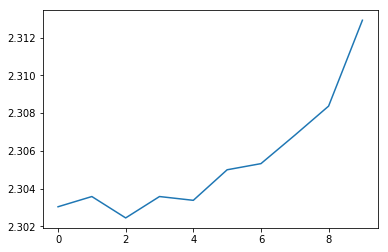

In [17]:
# let's look at the loss history!
plt.plot(loss_history)

In [10]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Exception: Not implemented!

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [ ]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

# Какой же точности мы добились на тестовых данных?

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))